# Scrapping of the website surf-report :

Surf report is  a popular surfing website which publish reports for several spots every day with pictures and comments. 
The objective is to retrieve this data to be able to compare the real data with the forecasts 

In [84]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument('--headless')
driver = webdriver.Chrome(ChromeDriverManager().install())



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [/Users/martinquievre/.wdm/drivers/chromedriver/mac64/96.0.4664.45/chromedriver] found in cache
/var/folders/wh/p86flhz52zn8x5836chj5zv00000gn/T/ipykernel_53888/3594162564.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


## Let's first try retrieving the infos of the report of Les Sables d'Olonne for one day 

In [85]:
import time
from selenium.webdriver.common.by import By
from selenium.webdriver import ActionChains

driver.get("https://www.surf-report.com/reports/sables-olonne-s1092.html")
driver.implicitly_wait(10)
ele = driver.find_element_by_css_selector('button.css-k8o10q')
ele.click()

/var/folders/wh/p86flhz52zn8x5836chj5zv00000gn/T/ipykernel_53888/754689600.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  ele = driver.find_element_by_css_selector('button.css-k8o10q')


 click on the J'accepte button for the RGPD

In [3]:
page_source = driver.page_source

In [6]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(page_source, 'lxml')

reports = []
report_selectors = soup.find_all('div', class_ = 'ti')
for report_selector in report_selectors:
    report = report_selector.get_text()
    reports.append(report)



titles = []

title_selectors = soup.find_all('div', class_ = 'top')

for title_selector in title_selectors:
    title = title_selector.get_text()
    titles.append(title)

print(titles, reports)



['Date', 'Vagues', 'Vent', "Plan d'eau", 'Niveau', 'Conseil'] ['Mercredi 22 Décembre à 10H30', '0.8 m à 1.0 m, 1.2 m à la série', 'Cross-shore moyen | Prévisions: Vent Est Sud Est, 23km/h.', 'Ridé', 'Tous niveaux', 'Sympa']


In [7]:
# import images in a new directory : 

newpath = r'/Users/martinquievre/Desktop/DSB/Projects/NLP/images'+'/' +reports[0] 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [8]:
import requests
import shutil
images = soup.find_all('div',class_ ='slides-photos')

for image in images :
    image.attrs['data-src']

    url_base = "https://www.surf-report.com/"
    url_ext = image.attrs['data-src']

    full_url = url_base + url_ext

    r = requests.get(full_url, stream=True) #Get request on full_url

    if r.status_code == 200:                     #200 status code = OK
       with open("images/" +'/'+reports[0]+'/' +image.attrs['data-src'][-15:], 'wb') as f: 
           r.raw.decode_content = True
           shutil.copyfileobj(r.raw, f)


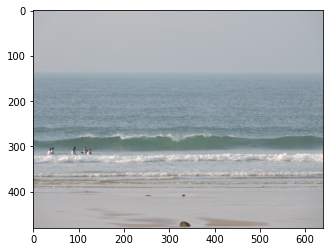

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for image in images :
    img = mpimg.imread("images/" +'/'+reports[0]+'/' +image.attrs['data-src'][-15:])
    imgplot = plt.imshow(img)
plt.show()



Now we'll just render all the data we have in one data frame, for memory purpose we'll only take the first raw

In [10]:
import pandas as pd
from IPython.display import Image, HTML

reports.append('<img src="/Users/martinquievre/Desktop/DSB/Projects/NLP/images/Mercredi 22 Décembre à 10H30/21122210673.JPG">')
df = pd.DataFrame(reports).transpose()
titles.append('Image')
df.columns = [titles]
HTML(df.to_html(escape=False))
titles
df

,Date,Vagues,Vent,Plan d'eau,Niveau,Conseil,Image
0,Mercredi 22 Décembre à 10H30,"0.8 m à 1.0 m, 1.2 m à la série",Cross-shore moyen | Prévisions: Vent Est Sud E...,Ridé,Tous niveaux,Sympa,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."


In [11]:
HTML(df.to_html(escape=False))


,Date,Vagues,Vent,Plan d'eau,Niveau,Conseil,Image
0,Mercredi 22 Décembre à 10H30,"0.8 m à 1.0 m, 1.2 m à la série","Cross-shore moyen | Prévisions: Vent Est Sud Est, 23km/h.",Ridé,Tous niveaux,Sympa,


## Let's now  try retrieving the infos of of one spot for all days, 

In [16]:
driver.get("https://www.surf-report.com/reports/sables-olonne-archives-s1092.html")
driver.implicitly_wait(10)
#ele = driver.find_element_by_css_selector('button.css-k8o10q')
#ele.click()
page_source = driver.page_source

We build a list of all the hyperlinks to a report in one archive page

In [18]:
soup = BeautifulSoup(page_source, 'lxml')

archives = soup.find_all('div',class_ ='title-bis')

urls = []
for each_archive in archives : 
    a = each_archive.find('a', href= True)
    href = a['href']

    urls.append(href)
#for each_date in dates :
#    source = driver.find_element_by_css_selector("div.date")
len(urls)

30

In [53]:
full_hyperlinks =[]
url_base = "https://www.surf-report.com"
for each_link in urls:
    full_hyperlinks.append(url_base + each_link)

full_hyperlinks[:5]

['https://www.surf-report.com/reports/sables-olonne-22-12-2021-10-30-1222211423.html',
 'https://www.surf-report.com/reports/sables-olonne-21-12-2021-10-30-1221217239.html',
 'https://www.surf-report.com/reports/sables-olonne-19-12-2021-10-30-1219213167.html',
 'https://www.surf-report.com/reports/sables-olonne-18-12-2021-10-30-1218216197.html',
 'https://www.surf-report.com/reports/sables-olonne-16-12-2021-10-30-1216213871.html']

Let's build a function that does that given an 'archive' page:

In [55]:
def get_links_archives(archive_page_url) :
    driver.get(archive_page_url)
    driver.implicitly_wait(10)
    #ele = driver.find_element_by_css_selector('button.css-k8o10q')
    #ele.click()
    page_source = driver.page_source

    soup = BeautifulSoup(page_source, 'lxml')

    archives = soup.find_all('div',class_ ='title-bis')

    urls = []

    for each_archive in archives : 
        a = each_archive.find('a', href= True)
        href = a['href']

        urls.append(href)
        full_hyperlinks =[]
    url_base = "https://www.surf-report.com"

    for each_link in urls:
        full_hyperlinks.append(url_base + each_link)

    return full_hyperlinks

## Let's try retrieving the datas of one page of archive 

In [28]:
driver.get('https://www.surf-report.com/reports/sables-olonne-22-12-2021-10-30-1222211423.html')
driver.implicitly_wait(10)
ele = driver.find_element_by_css_selector('button.css-k8o10q')
ele.click()    

/var/folders/wh/p86flhz52zn8x5836chj5zv00000gn/T/ipykernel_53888/4167663838.py:3: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  ele = driver.find_element_by_css_selector('button.css-k8o10q')


In [44]:
full_hyperlinks[:3]

['https://www.surf-report.com/reports/sables-olonne-22-12-2021-10-30-1222211423.html',
 'https://www.surf-report.com/reports/sables-olonne-21-12-2021-10-30-1221217239.html',
 'https://www.surf-report.com/reports/sables-olonne-19-12-2021-10-30-1219213167.html']

In [52]:
def scrap_archive_page(list_links):

    for each_url in list_links:
        
        #TEXT DATA 

        #driver.get("'" + each_url.replace("'", "") + "'")
        driver.get(each_url)
        driver.implicitly_wait(10)
        #ele = driver.find_element_by_css_selector('button.css-k8o10q')
        #ele.click()

        page_source = driver.page_source
        soup = BeautifulSoup(page_source, 'lxml')

        reports = []
        report_selectors = soup.find_all('div', class_ = 'ti')

        for report_selector in report_selectors:
            report = report_selector.get_text()
            reports.append(report)

        titles = []

        title_selectors = soup.find_all('div', class_ = 'top')

        for title_selector in title_selectors:
            title = title_selector.get_text()
            titles.append(title)


    ## HERE WE ONLY TAKE 1 PICTURE FOR MEMORY PURPOSE
        newpath = r'/Users/martinquievre/Desktop/DSB/Projects/NLP/images'+'/' +reports[0] 
        if not os.path.exists(newpath):
            os.makedirs(newpath)


        images = soup.find_all('div',class_ ='slides-photos')

        images[0].attrs['data-src']

        url_base = "https://www.surf-report.com/"
        url_ext = images[0].attrs['data-src']

        full_url = url_base + url_ext

        r = requests.get(full_url, stream=True) #Get request on full_url

        if r.status_code == 200:                     #200 status code = OK
            with open("images/" +'/'+reports[0]+'/' +images[0].attrs['data-src'][-15:], 'wb') as f: 
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f)
    ## HERE WE DEAL WITH THE DF


        reports.append('<img src="' + newpath +'/' + reports[0] +'/' + images[0].attrs['data-src'][-15:] + '">')
        df.loc[len(df)] = reports

    return df


In [50]:
scrap_archive_page(full_hyperlinks)

,Date,Vagues,Vent,Plan d'eau,Niveau,Conseil,Image
0,Mercredi 22 Décembre à 10H30,"0.8 m à 1.0 m, 1.2 m à la série",Cross-shore moyen | Prévisions: Vent Est Sud E...,Ridé,Tous niveaux,Sympa,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
1,Mercredi 22 Décembre à 10H30,"0.8 m à 1.0 m, 1.2 m à la série",Cross-shore moyen | Prévisions: Vent Est Sud E...,Ridé,Tous niveaux,Sympa,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
2,Mardi 21 Décembre à 10H30,"0.0 m à 0.2 m, 0.2 m à la série","Side-shore moyen | Prévisions: Vent Est, 21km/h.",Propre,Tous niveaux,C'est FLAT,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
3,Dimanche 19 Décembre à 10H30,"0.4 m à 0.6 m, 0.6 m à la série","Off-shore moyen | Prévisions: Vent Est, 24km/h.",Propre,Tous niveaux,Surfable,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
4,Samedi 18 Décembre à 10H30,"0.2 m à 0.4 m, 0.6 m à la série","Side-shore moyen | Prévisions: Vent Est, 22km/h.",Propre,Tous niveaux,"Petit, sortez les longboards !","<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
5,Jeudi 16 Décembre à 10H30,"0.6 m à 0.8 m, 1.2 m à la série",Off-shore fort | Prévisions: Vent Est Nord Est...,Propre,Tous niveaux,Sympa,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
6,Mercredi 15 Décembre à 10H30,"0.8 m à 1.0 m, 1.4 m à la série",Side-shore faible | Prévisions: Vent Est Nord ...,Propre,Tous niveaux,Sympa,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
7,Mardi 14 Décembre à 10H45,"1.0 m à 1.2 m, 1.6 m à la série","Side-shore faible | Prévisions: Vent Est, 10km/h.",Propre,Tous niveaux,Sympa,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
8,Lundi 13 Décembre à 10H45,"1.4 m à 1.6 m, 2.0 m à la série",Side-shore faible | Prévisions: Vent Est Sud E...,Propre,Tous niveaux,Sympa,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."
9,Dimanche 12 Décembre à 10H30,"1.2 m à 1.4 m, 1.8 m à la série",Pas de vent | Prévisions: Vent Ouest Sud Ouest...,Glassy,Tous niveaux,Sympa,"<img src=""/Users/martinquievre/Desktop/DSB/Pro..."


## Now let's try to scrap several archive pages with our functions

When we go back in the archives, we realize that most of our surf reports photos have most likely been deleted  by the website so we'll redo a function that gets the info of a page without the image

In [86]:
def scrap_text_archive_page(list_links):
    # 1st iteration to create the dataset

    driver.get(list_links[0])
    driver.implicitly_wait(10)

    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'lxml')

    reports = []
    report_selectors = soup.find_all('div', class_ = 'ti')

    for report_selector in report_selectors:
        report = report_selector.get_text()
        reports.append(report)

    titles = []

    title_selectors = soup.find_all('div', class_ = 'top')

    for title_selector in title_selectors:
        title = title_selector.get_text()
        titles.append(title)

    # initiate the dataframe
    df = pd.DataFrame(reports).transpose()
    df.columns = [titles]


    for each_url in list_links[1:]:
        
        #TEXT DATA 

        driver.get(each_url)
        driver.implicitly_wait(10)
        #ele = driver.find_element_by_css_selector('button.css-k8o10q')
        #ele.click()

        page_source = driver.page_source
        soup = BeautifulSoup(page_source, 'lxml')

        reports = []
        report_selectors = soup.find_all('div', class_ = 'ti')

        for report_selector in report_selectors:
            report = report_selector.get_text()
            reports.append(report)

        titles = []

        title_selectors = soup.find_all('div', class_ = 'top')

        for title_selector in title_selectors:
            title = title_selector.get_text()
            titles.append(title)


     ## HERE WE append TO THE DF
        df.loc[len(df)] = reports

    return df


In [69]:
data = scrap_text_archive_page(full_hyperlinks)


,Date,Vagues,Vent,Plan d'eau,Niveau,Conseil
0,Mercredi 22 Décembre à 10H30,"0.8 m à 1.0 m, 1.2 m à la série",Cross-shore moyen | Prévisions: Vent Est Sud E...,Ridé,Tous niveaux,Sympa
1,Mardi 21 Décembre à 10H30,"0.0 m à 0.2 m, 0.2 m à la série","Side-shore moyen | Prévisions: Vent Est, 21km/h.",Propre,Tous niveaux,C'est FLAT
2,Dimanche 19 Décembre à 10H30,"0.4 m à 0.6 m, 0.6 m à la série","Off-shore moyen | Prévisions: Vent Est, 24km/h.",Propre,Tous niveaux,Surfable
3,Samedi 18 Décembre à 10H30,"0.2 m à 0.4 m, 0.6 m à la série","Side-shore moyen | Prévisions: Vent Est, 22km/h.",Propre,Tous niveaux,"Petit, sortez les longboards !"
4,Jeudi 16 Décembre à 10H30,"0.6 m à 0.8 m, 1.2 m à la série",Off-shore fort | Prévisions: Vent Est Nord Est...,Propre,Tous niveaux,Sympa
5,Mercredi 15 Décembre à 10H30,"0.8 m à 1.0 m, 1.4 m à la série",Side-shore faible | Prévisions: Vent Est Nord ...,Propre,Tous niveaux,Sympa
6,Mardi 14 Décembre à 10H45,"1.0 m à 1.2 m, 1.6 m à la série","Side-shore faible | Prévisions: Vent Est, 10km/h.",Propre,Tous niveaux,Sympa
7,Lundi 13 Décembre à 10H45,"1.4 m à 1.6 m, 2.0 m à la série",Side-shore faible | Prévisions: Vent Est Sud E...,Propre,Tous niveaux,Sympa
8,Dimanche 12 Décembre à 10H30,"1.2 m à 1.4 m, 1.8 m à la série",Pas de vent | Prévisions: Vent Ouest Sud Ouest...,Glassy,Tous niveaux,Sympa
9,Samedi 11 Décembre à 11H30,"1.2 m à 1.4 m, 1.8 m à la série","Cross-shore faible | Prévisions: Vent Sud, 1km/h.",Propre,Tous niveaux,Sympa


In [76]:
full_data =data
full_data


,Date,Vagues,Vent,Plan d'eau,Niveau,Conseil
0,Mercredi 22 Décembre à 10H30,"0.8 m à 1.0 m, 1.2 m à la série",Cross-shore moyen | Prévisions: Vent Est Sud E...,Ridé,Tous niveaux,Sympa
1,Mardi 21 Décembre à 10H30,"0.0 m à 0.2 m, 0.2 m à la série","Side-shore moyen | Prévisions: Vent Est, 21km/h.",Propre,Tous niveaux,C'est FLAT
2,Dimanche 19 Décembre à 10H30,"0.4 m à 0.6 m, 0.6 m à la série","Off-shore moyen | Prévisions: Vent Est, 24km/h.",Propre,Tous niveaux,Surfable
3,Samedi 18 Décembre à 10H30,"0.2 m à 0.4 m, 0.6 m à la série","Side-shore moyen | Prévisions: Vent Est, 22km/h.",Propre,Tous niveaux,"Petit, sortez les longboards !"
4,Jeudi 16 Décembre à 10H30,"0.6 m à 0.8 m, 1.2 m à la série",Off-shore fort | Prévisions: Vent Est Nord Est...,Propre,Tous niveaux,Sympa
5,Mercredi 15 Décembre à 10H30,"0.8 m à 1.0 m, 1.4 m à la série",Side-shore faible | Prévisions: Vent Est Nord ...,Propre,Tous niveaux,Sympa
6,Mardi 14 Décembre à 10H45,"1.0 m à 1.2 m, 1.6 m à la série","Side-shore faible | Prévisions: Vent Est, 10km/h.",Propre,Tous niveaux,Sympa
7,Lundi 13 Décembre à 10H45,"1.4 m à 1.6 m, 2.0 m à la série",Side-shore faible | Prévisions: Vent Est Sud E...,Propre,Tous niveaux,Sympa
8,Dimanche 12 Décembre à 10H30,"1.2 m à 1.4 m, 1.8 m à la série",Pas de vent | Prévisions: Vent Ouest Sud Ouest...,Glassy,Tous niveaux,Sympa
9,Samedi 11 Décembre à 11H30,"1.2 m à 1.4 m, 1.8 m à la série","Cross-shore faible | Prévisions: Vent Sud, 1km/h.",Propre,Tous niveaux,Sympa


Now let's parse all the archive pages to retrieve all the data for Les Sables d'Olonne

In [89]:
base_archive_url = 'https://www.surf-report.com/reports/sables-olonne-archives-s1092.html'

for i in range(1, 88):
    extended_archive_url = base_archive_url + '?pageId=' + str(i)
    report_links = get_links_archives(extended_archive_url)
    data = scrap_text_archive_page(full_hyperlinks)
    full_data = pd.concat([full_data, data], ignore_index=True)
    print(extended_archive_url)


MaxRetryError: HTTPConnectionPool(host='localhost', port=61663): Max retries exceeded with url: /session/b0c906a192fce35c5f02e63a201c7581/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fa4e99d2400>: Failed to establish a new connection: [Errno 61] Connection refused'))